In [1]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.optim as optim
import cv2
from torchvision.transforms import CenterCrop

ModuleNotFoundError: No module named 'torch._prims_common'

In [2]:
import zipfile

# Path to your ZIP file
zip_file_path = "C:\\Users\\Bhargavi\\OneDrive\\Desktop\\USLL\\Dataset fetus.zip"

# Path to the directory where you want to extract the files
extract_dir = "C:\\Users\\Bhargavi\\OneDrive\\Desktop\\USLL\\Dataset fetus"

# Open the ZIP file in read mode
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all files to the specified directory
    zip_ref.extractall(extract_dir)

print("Extraction complete.")



Extraction complete.


Checking if Image folder and Files are present:

In [3]:
import os

# Path to your test set directory
train_set_dir = 'C:\\Users\\Bhargavi\\OneDrive\\Desktop\\USLL\\Dataset fetus\\train'

# List files in the test set directory
files = os.listdir(train_set_dir)

# Get the number of files
num_files = len(files)

print(num_files)


151


In [4]:
import os

# Path to your test set directory
validation_set_dir = 'C:\\Users\\Bhargavi\\OneDrive\\Desktop\\USLL\\Dataset fetus\\validation'

# List files in the test set directory
files = os.listdir(validation_set_dir)

# Get the number of files
num_files = len(files)

print(num_files)


38


In [5]:
import os
import cv2

base_path = "C:\\Users\\Bhargavi\\OneDrive\\Desktop\\USLL\\Dataset fetus"
train_set_dir = os.path.join(base_path, "train")
validation_set_dir = os.path.join(base_path, "validation")

def count_files(directory):
    files = os.listdir(directory)
    return len(files)

def analyze_images(directory):
    max_width, max_height = 0, 0
    min_width, min_height = 2000, 2000
    file_names = []
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        if os.path.isfile(file_path):
            file_names.append(file_path)
            img = cv2.imread(file_path, cv2.IMREAD_COLOR)
            if img is not None:
                height, width, _ = img.shape
                max_width = max(max_width, width)
                max_height = max(max_height, height)
                min_width = min(min_width, width)
                min_height = min(min_height, height)
            else:
                print(f"Failed to read image: {file_path}")
    return file_names, max_width, max_height, min_width, min_height

train_count = count_files(train_set_dir)
validation_count = count_files(validation_set_dir)

train_files, train_max_width, train_max_height, train_min_width, train_min_height = analyze_images(train_set_dir)
validation_files, validation_max_width, validation_max_height, validation_min_width, validation_min_height = analyze_images(validation_set_dir)

print(f"We have {train_count} images and annotations in the train set.")
print(f"We have {validation_count} images in the validation set.")
print(f"Train set - Min Image Width: {train_min_width}, Min Image Height: {train_min_height}, Max Image Width: {train_max_width}, Max Image Height: {train_max_height}")
print(f"Validation set - Min Image Width: {validation_min_width}, Min Image Height: {validation_min_height}, Max Image Width: {validation_max_width}, Max Image Height: {validation_max_height}")


We have 151 images and annotations in the train set.
We have 38 images in the validation set.
Train set - Min Image Width: 672, Min Image Height: 389, Max Image Width: 1600, Max Image Height: 1600
Validation set - Min Image Width: 672, Min Image Height: 389, Max Image Width: 1600, Max Image Height: 1600


## Image Preprocessing 

In [6]:
n_train_cnt = 0
n_validation_cnt = 0
train_file_name = []
validation_file_name = []
max_width = 0
max_height = 0
min_width = 2000
min_height = 2000
base_path = "C:\\Users\\Bhargavi\\OneDrive\\Desktop\\USLL\\Dataset fetus"
for path in os.listdir(base_path + "/train" ):
    f_path = os.path.join(base_path + "/train", path)
    if os.path.isfile(f_path):
        if '_Annotation' not in f_path:
          n_train_cnt += 1
          train_file_name.append(f_path[0:-4])
          img = cv2.imread(f_path, cv2.IMREAD_COLOR)
          if img is not None:
              if img.shape[0] > max_width:
                  max_width = img.shape[0]
              if img.shape[1] > max_height:
                  max_height = img.shape[1]
              if img.shape[0] < min_width:
                  min_width = img.shape[0]
              if img.shape[1] < min_height:
                  min_height = img.shape[1]
          else:
              print(f"Failed to read image: {f_path}")

for path in os.listdir(base_path + "/validation" ):
    f_path = os.path.join(base_path + "/validation", path)
    if os.path.isfile(f_path):
        n_validation_cnt += 1
        validation_file_name.append(f_path[0:-4])
        img = cv2.imread(f_path, cv2.IMREAD_COLOR)
        if img is not None:
            if img.shape[0] > max_width:
                max_width = img.shape[0]
            if img.shape[1] > max_height:
                max_height = img.shape[1]
            if img.shape[0] < min_width:
                min_width = img.shape[0]
            if img.shape[1] < min_height:
                min_height = img.shape[1]
        else:
            print(f"Failed to read image: {f_path}")
print(f'We Have {n_train_cnt} Images and {n_train_cnt} Annotations in Train Set  and {n_validation_cnt} Images in Test Set. ')
print(f"Min Image Width: {min_width} - Min Image Height: {min_height}")
print(f"Max Image Width: {max_width} - Max Image Height: {max_height}")

We Have 151 Images and 151 Annotations in Train Set  and 38 Images in Test Set. 
Min Image Width: 389 - Min Image Height: 672
Max Image Width: 1600 - Max Image Height: 1600


In [7]:
def seed_everything(seed=42):
	np.random.seed(seed)
	os.environ['PYTHONHASHSEED']=str(seed)
	os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8" # added so that Colab can run GPU for given Model Configuration
	np.random.seed(seed)
	torch.manual_seed(seed)

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

def read_images(file_name, img_width, img_height, title = "", suffix = "", transform = False):
  i = 0
  print('-'*50)
  print(title, '- Reading Images...')
  print('-'*50)
  j = 0
  cntr = 0
  mul = 1
  if transform:
    mul = 1
  total = len(file_name)

  channel = 3
  if 'Annotation' in suffix:
    channel = 1
  X_train = torch.tensor(np.ndarray((mul * total, channel, img_width, img_height), dtype=np.uint8))


  for label in file_name:
      img = cv2.imread(label + suffix, cv2.IMREAD_COLOR)
      if img is None:
        print(f"Failed to load image: {label + suffix}")
        continue
      img1 = cv2.cvtColor(img, cv2.IMREAD_COLOR)
      if channel == 1:
        image = cv2.imread(label + suffix, 0)
        im = image.copy()
        im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
        contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for c in contours:
            ellipse = cv2.fitEllipse(c)
            cv2.ellipse(im, ellipse, (255,255,255), -1)
        img1 = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

      # Resize Images
      scale_width =   img.shape[0] / img_width
      if img.shape[1] / img_height > scale_width:
        scale_width = img.shape[1] / img_height
      img1 = cv2.resize(img1, (int(img.shape[1] / scale_width), int(img.shape[0] / scale_width)))

      # Center Image
      top = int((img_height-img1.shape[1])/2)
      bottom = img_height-img1.shape[1] - top
      left = int((img_width-img1.shape[0])/2)
      right = img_width-img1.shape[0] - left
      img1 = cv2.copyMakeBorder(img1,left, right, top, bottom,  borderType=cv2.BORDER_CONSTANT, value=(0,0,0,0))

      # transform Image
      if transform:
        base_img = []
        base_img.append(img1)
        base_img.append(rotate_image(img1, 30))
        base_img.append(rotate_image(img1, 60))
        if '_Annotation' not in suffix:
          base_img.append(cv2.blur(np.array(img1) ,(10,10)))
        else:
          base_img.append(img1)
        base_img.append(cv2.flip(np.array(img1) ,0))
        base_img.append(cv2.flip(np.array(img1) ,1))
        base_img.append(cv2.flip(np.array(img1) ,-1))
        for m in range(0, 1):
          img = base_img[m]
          # Convert to n,c,w,h
          image = torch.from_numpy(img)
          image = image[np.newaxis, :]
          if channel == 3:
            image = image.permute(0, 3, 1, 2)
          X_train[j + m] = image
        j += 4
      else:
        image = torch.from_numpy(img1)
        image = image[np.newaxis, :]
        if channel == 3:
          image = image.permute(0, 3, 1, 2)
        X_train[j] = image
        j += 1

      if cntr % 100 == 0:
          print('Read: {0}/{1} images'.format(cntr, total))
      cntr += 1

  print(title, ' - Reading Completed')
  return X_train


In [8]:
for path in train_file_name:
    print(path)

for path in validation_file_name:
    print(path)


C:\Users\Bhargavi\OneDrive\Desktop\USLL\Dataset fetus/train\frame_000009
C:\Users\Bhargavi\OneDrive\Desktop\USLL\Dataset fetus/train\frame_000015
C:\Users\Bhargavi\OneDrive\Desktop\USLL\Dataset fetus/train\frame_000024
C:\Users\Bhargavi\OneDrive\Desktop\USLL\Dataset fetus/train\frame_000034
C:\Users\Bhargavi\OneDrive\Desktop\USLL\Dataset fetus/train\frame_000066
C:\Users\Bhargavi\OneDrive\Desktop\USLL\Dataset fetus/train\frame_000067
C:\Users\Bhargavi\OneDrive\Desktop\USLL\Dataset fetus/train\frame_000076
C:\Users\Bhargavi\OneDrive\Desktop\USLL\Dataset fetus/train\frame_000085
C:\Users\Bhargavi\OneDrive\Desktop\USLL\Dataset fetus/train\frame_000088
C:\Users\Bhargavi\OneDrive\Desktop\USLL\Dataset fetus/train\frame_000091
C:\Users\Bhargavi\OneDrive\Desktop\USLL\Dataset fetus/train\frame_000099
C:\Users\Bhargavi\OneDrive\Desktop\USLL\Dataset fetus/train\frame_000108
C:\Users\Bhargavi\OneDrive\Desktop\USLL\Dataset fetus/train\frame_000110
C:\Users\Bhargavi\OneDrive\Desktop\USLL\Dataset fet

In [9]:
import os
import cv2
import numpy as np

base_path = "C:\\Users\\Bhargavi\\OneDrive\\Desktop\\USLL\\Dataset fetus"
train_set_dir = os.path.join(base_path, "train")
validation_set_dir = os.path.join(base_path, "validation")

# Generate list of file names in the training and validation sets
train_file_name = [os.path.join(train_set_dir, file) for file in os.listdir(train_set_dir)]
validation_file_name = [os.path.join(validation_set_dir, file) for file in os.listdir(validation_set_dir)]

def read_images(file_names, img_width, img_height, title="", suffix=".png", transform=False):
    print('-'*50)
    print(title, '- Reading Images...')
    print('-'*50)
    images = []
    for file_path in file_names:
        img = cv2.imread(file_path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"Failed to load image: {file_path}")
            continue
        img = cv2.resize(img, (img_width, img_height))  # Resize the image to the specified dimensions
        images.append(img)
    print(title, ' - Reading Completed')
    return np.array(images)

img_width = 224
img_height = 224

# Reading Train Images
X_train = read_images(train_file_name[:151], img_width, img_height, title="Train Images", suffix=".png", transform=False)
Y_train = read_images(train_file_name[:151], img_width, img_height, title="Train Images", suffix=".png", transform=False)

X_validation = read_images(validation_file_name[:38], img_width, img_height, title="Validation Images", suffix=".png", transform=False)

print('Total Train Image Set Shape: ', X_train.shape)
print('Total Validation Image Set Shape: ', X_validation.shape)

def read_images(file_names, img_width, img_height, title="", suffix=".png", transform=False):
    print('-'*50)
    print(title, '- Reading Images...')
    print('-'*50)
    images = []
    for file_path in file_names:
        img = cv2.imread(file_path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"Failed to load image: {file_path}")
            continue
        img = cv2.resize(img, (img_width, img_height))  # Resize the image to the specified dimensions
        images.append(img)
    print(title, ' - Reading Completed')
    return np.array(images)



--------------------------------------------------
Train Images - Reading Images...
--------------------------------------------------
Train Images  - Reading Completed
--------------------------------------------------
Train Images - Reading Images...
--------------------------------------------------
Train Images  - Reading Completed
--------------------------------------------------
Validation Images - Reading Images...
--------------------------------------------------
Validation Images  - Reading Completed
Total Train Image Set Shape:  (151, 224, 224, 3)
Total Validation Image Set Shape:  (38, 224, 224, 3)


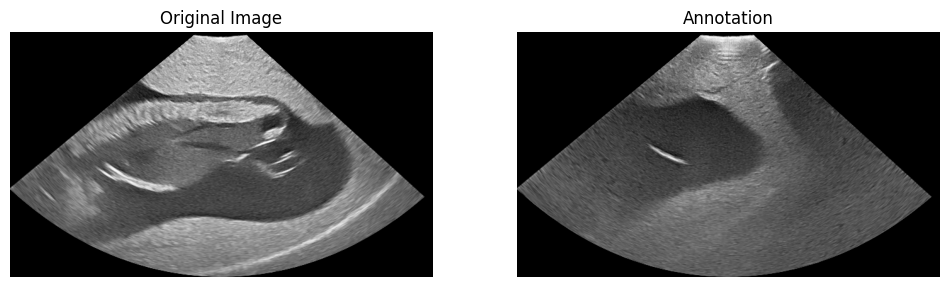

In [10]:
import cv2
import matplotlib.pyplot as plt

# Load an example image and annotation
image_path = "C:\\Users\\Bhargavi\\OneDrive\\Desktop\\USLL\\Dataset fetus\\Train\\frame_000110.png"
annotation_path = "C:\\Users\\Bhargavi\\OneDrive\\Desktop\\USLL\\Dataset fetus\\Train\\frame_000307.png"

# Load the image and annotation using cv2
image = cv2.imread(image_path)
annotation = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)

# Display the original image and annotation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(annotation, cmap='gray')
plt.title('Annotation')
plt.axis('off')

plt.show()


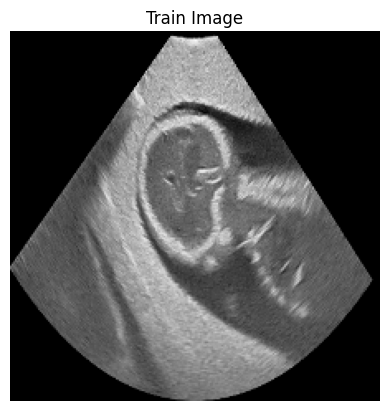

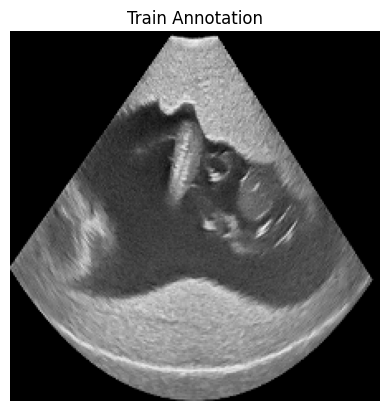

In [11]:
def show_image(image, title):
    if isinstance(image, torch.Tensor):
        # If the image is a PyTorch tensor
        if image.shape[0] == 1:
            image = image.squeeze().cpu().numpy()  # Convert to NumPy array
            print("Annotation Mask - Min Value:", image.min(), "Max Value:", image.max())
            plt.imshow(image, cmap='jet')  # Apply a colormap for better visibility
        else:
            image = image.permute(1, 2, 0).cpu().numpy()  # Convert to NumPy array
            plt.imshow(image)
    elif isinstance(image, np.ndarray):
        # If the image is a NumPy array
        if image.shape[2] == 1:
            image = image.squeeze()  # Remove the single channel dimension
            print("Annotation Mask - Min Value:", image.min(), "Max Value:", image.max())
            plt.imshow(image, cmap='jet')
        else:
            plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.show()

# Display train images
show_image(X_train[0], title='Train Image')
show_image(Y_train[6], title='Train Annotation') 


# define the DataLoaders

In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Placeholder data for demonstration
X_train = torch.randn(100, 3, 224, 224)  # Assuming shape (100, 3, 224, 224) for X_train
Y_train = torch.randn(100, 1, 224, 224)  # Assuming shape (100, 1, 224, 224) for Y_train
X_validation = torch.randn(20, 3, 224, 224)  # Assuming shape (20, 3, 224, 224) for X_validation
Y_validation = torch.randn(20, 1, 224, 224)  # Assuming shape (20, 1, 224, 224) for Y_validation

# Creating Tensor Datasets for training and validation data and normalizing them
train_dataset = TensorDataset(X_train/255, Y_train/255)
validation_dataset = TensorDataset(X_validation/255, Y_validation/255)

# Defining batch size for DataLoader
batch_size = 32

# Creating DataLoader for training data
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

# Creating DataLoader for validation data
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)



Let us build custom encoder - decoder model. We try to mimic SegNet Architecture - Though with lesser number of channels across the model since more channels causes Colab GPU to go over memory.

Our Encoder will Convolve with Channels: 3, 16, 32, 64 and then Decoder will go back to 64, 32, 16, 1 - We use Sigmoid and BCE Loss to calculate the final Segmentation Mask:

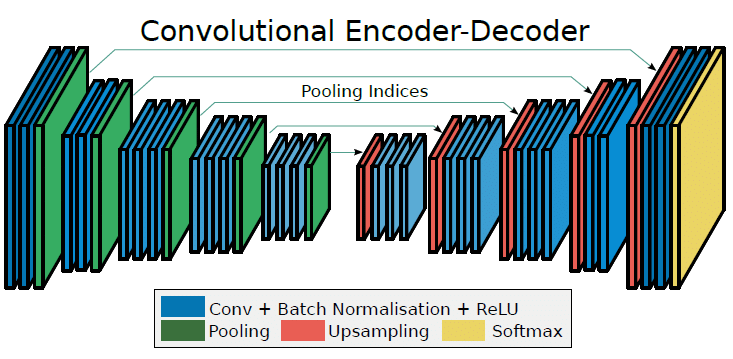

In [13]:
class ResEncoderBlock(nn.Module):
  def __init__(self, inChannels, outChannels, layers = 2):
    super().__init__()
    self.conv1 = nn.Conv2d(inChannels, outChannels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(outChannels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(outChannels, outChannels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(outChannels)
    self.layers = layers
    self.MaxEn = nn.MaxPool2d(2, stride=2, return_indices=True)
    self.size = 0

  def forward(self, x):
    # CONV -> Batch Norm -> RELU
    x = self.relu(self.bn1(self.conv1(x)))
    for i in range(1, self.layers):
      x = self.relu(self.bn2(self.conv2(x)))
    x, ind1 = self.MaxEn(x)
    return x, ind1

class ResDecoderBlock(nn.Module):
  def __init__(self, inChannels, outChannels, layers = 2):
    super().__init__()
    self.conv1 = nn.Conv2d(inChannels, outChannels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(outChannels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(outChannels, outChannels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(outChannels)
    self.layers = layers
    self.MaxDe = nn.MaxUnpool2d(2, stride=2)

  def forward(self, x, poolingIndices, size):

    x = self.MaxDe(x, poolingIndices, output_size =size)
    x = self.relu(self.bn1(self.conv1(x)))
    for i in range(1, self.layers):
      x = self.relu(self.bn2(self.conv2(x)))

    return x

In [14]:
class ResEncoder(nn.Module):
  def __init__(self, channels=(3, 64, 128, 256, 512, 512), layers=(2,2,3,3,3)):
    super().__init__()
    self.encoderBlocks = nn.ModuleList(
    [ResEncoderBlock(channels[i], channels[i + 1], layers[i]) for i in range(len(channels) - 1)])

  def forward(self, x):
    resBlockOut = []
    resBlockIndices = []
    resSize = []
    i = 0
    for block in self.encoderBlocks:

      x, ind = block(x)
      resBlockOut.append(x)
      resBlockIndices.append(ind)
      size = x.size()
      resSize.append(size)
      #print(size, x.shape, ind.shape)
    return (resBlockOut, resBlockIndices, resSize)



In [15]:
class ResDecoder(nn.Module):
  def __init__(self, channels=(512, 512, 256, 128, 64, 32), layers=(3,3,3,2,2)):
    super().__init__()
    self.channels = channels
    self.decoderBlocks = nn.ModuleList(
      [ResDecoderBlock(channels[i], channels[i + 1], layers[i]) for i in range(len(channels) - 1)])

  def forward(self, x, encoderIndices, encoderSize ):
    i = 0
    for block in self.decoderBlocks:
      x = block(x, encoderIndices[i], encoderSize[i])
      i+= 1
    return x

In [16]:
class customEncoderDecoder(nn.Module):
  def __init__(self, encoderChannels=(3, 64, 128, 256, 512, 512),
               encoderLayer = (2,2,3,3,3) ,
               decoderChannels=(512, 512, 256, 128, 64, 32),
               decoderLayer = (3,3,3,2,2),
               outClassCount=1):
    super().__init__()
    self.encoder = ResEncoder(encoderChannels, encoderLayer)
    self.decoder = ResDecoder(decoderChannels, decoderLayer)
    self.head = nn.Conv2d(decoderChannels[-1], outClassCount, 1)
    self.outputSize = (img_width,  img_height)

  def forward(self, x):
    (encoderOutput, encoderIndices, encoderSizes) = self.encoder(x)
    decoderOutput = self.decoder(encoderOutput[::-1][0], encoderIndices[::-1], encoderSizes[::-1][1:])
    map = self.head(decoderOutput)
    map = F.interpolate(map, self.outputSize)
    return map

In [17]:
from torch.autograd import Variable
from torch import Tensor
from sklearn import metrics
import seaborn as sns
import warnings

class Trainer:
    def __init__(self, net, criterion, optimizer, epoch, train_loader, test_loader, train_len, test_len):
        self.epoch = epoch
        self.model = net
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.train_len = train_len
        self.test_len = test_len
        self.training_loss = []
        self.test_loss = []
        self.test_dice = []
        self.training_dice = []

    def train_batch(self):

        iterations = (int(len(self.train_loader.dataset) / self.train_loader.batch_size)) + 1

        print(f'Running {iterations} Batches of Size {self.train_loader.batch_size} - Over {self.epoch} Epochs')

        for epoch in range(self.epoch):
          self.model.train()
          train_loss = 0
          test_loss = 0
          for (i, (x, y)) in enumerate(self.train_loader):
            (x, y) = (x.to(device), y.to(device))
            pred = self.model(x)
            loss = self.criterion(pred, y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()


          with torch.no_grad():
            self.model.eval()
            for (x, y) in self.test_loader:
              (x, y) = (x.to(device), y.to(device))
              pred = self.model(x)
              loss = self.criterion(pred, y)
              test_loss += loss.item()

          avg_train_loss = train_loss / self.train_len
          avg_test_loss = test_loss / self.test_len

          self.training_loss.append(avg_train_loss)
          self.test_loss.append(avg_test_loss)

          _, train_dice_score = self.predict_mask_tensor(self.train_loader)
          _, test_dice_score = self.predict_mask_tensor(self.test_loader)
          self.training_dice.append(train_dice_score.item())
          self.test_dice.append(test_dice_score.item())

          print(f'Epoch: {(epoch + 1)}/{self.epoch} | ' +
                f'Training Loss: {avg_train_loss} ' +
                    f'| Test Loss: {avg_test_loss}')
        print("=" * 60)
        print(f'Training Dice Score: {self.training_dice[-1]}')
        print(f'Validation Dice Score: {self.test_dice[-1]}')
        print("=" * 60)

    def predict_mask_tensor(self, loader):
      self.model.eval()
      all_images = []
      dice_score = 0
      cntr = 0
      with torch.no_grad():
          for (i, (x, y)) in enumerate(train_loader):
            (x, Y) = (x.to(device), y.to(device))
            prediction_m = self.model(x)
            prediction_m = prediction_m.squeeze()
            prediction_m = torch.sigmoid(prediction_m)
            #prediction_m = prediction_m.cpu().numpy()
            prediction_m = prediction_m.type(torch.FloatTensor)
            for i in range(0, prediction_m.shape[0]):
              all_images.append(prediction_m[i])
            dice_score += self.get_dice_coeff(y, prediction_m)
            prediction_m = (prediction_m > 0.5) * 255
            cntr += 1
          dice_score = dice_score / cntr

      return all_images, dice_score

    def predict_mask(self, loader):
      self.model.eval()
      all_images = []
      dice_score = 0
      cntr = 0
      with torch.no_grad():
          for (i, (x, y)) in enumerate(train_loader):
            (x, Y) = (x.to(device), y.to(device))
            prediction_m = self.model(x)
            prediction_m = prediction_m.squeeze()
            prediction_m = torch.sigmoid(prediction_m)
            prediction_m = prediction_m.type(torch.FloatTensor)
            dice_score += self.get_dice_coeff(y, prediction_m)
            prediction_m = (prediction_m > 0.5) * 255
            prediction_m = prediction_m.cpu().numpy()
            prediction_m = prediction_m.astype(np.uint8)
            for i in range(0, prediction_m.shape[0]):
              all_images.append(prediction_m[i])
              cntr += 1
          dice_score = dice_score / cntr

      return all_images, dice_score

    def predict_mask_test_data(self, loader):
      self.model.eval()
      all_images = []
      dice_score = 0
      cntr = 0
      with torch.no_grad():
          for (i, x) in enumerate(train_loader):
            x = x[0].to(device)
            prediction_m = self.model(x)
            prediction_m = prediction_m.squeeze()
            prediction_m = torch.sigmoid(prediction_m)
            prediction_m = prediction_m.type(torch.FloatTensor)
            prediction_m = (prediction_m > 0.5) * 255
            prediction_m = prediction_m.cpu().numpy()
            prediction_m = prediction_m.astype(np.uint8)
            for i in range(0, prediction_m.shape[0]):
              all_images.append(prediction_m[i])
              cntr += 1
          dice_score = dice_score / cntr

      return all_images, dice_score

    def get_dice_score(self, input, target):
        epsilon = 0.000001
        inp = input.to(device).flatten()
        tar = target.to(device).flatten()
        inter = torch.sum(inp * tar)
        union = torch.sum(inp) + torch.sum(tar) + epsilon

        t = (2 * inter.float() + epsilon) / union.float()
        #print(t, inp.max(), target.max())
        return t

    def get_dice_coeff(self, input, target):
        s = torch.FloatTensor(1).zero_().to(device)

        for i, c in enumerate(zip(input, target)):
          s = s + self.get_dice_score(c[0], c[1])

        return s / (i + 1)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.fc = nn.Linear(32 * 28 * 28, 10)  # Assuming input image size is 224x224

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2, 2)
        x = x.view(-1, 32 * 28 * 28)
        x = self.fc(x)
        return x

model = YourModel()

# Define your criterion (loss function) and other necessary components
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check if GPU is available, then use it, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the correct device
model.to(device)

# Assuming you have a train_loader, you can then proceed with your training loop


YourModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=25088, out_features=10, bias=True)
)

In [19]:
# Modify the Trainer class to include the epoch loop in the train_batch method
class Trainer:
    def __init__(self, model, criterion, optimizer, max_epoch, train_loader, validation_loader, train_len, validation_len):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.max_epoch = max_epoch
        self.train_loader = train_loader
        self.validation_loader = validation_loader
        self.train_len = train_len
        self.validation_len = validation_len

    def train_batch(self):
        train_losses = []
        validation_losses = []

        for epoch in range(self.max_epoch):
            train_loss = 0.0
            validation_loss = 0.0

            self.model.train()
            for i, (inputs, targets) in enumerate(self.train_loader):
                inputs, targets = inputs.to(device), targets.to(device)

                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

            # Calculate validation loss
            if self.validation_loader is not None:
                self.model.eval()
                with torch.no_grad():
                    for inputs, targets in self.validation_loader:
                        inputs, targets = inputs.to(device), targets.to(device)
                        outputs = self.model(inputs)
                        loss = self.criterion(outputs, targets)
                        validation_loss += loss.item()

            train_loss /= len(self.train_loader)
            validation_loss /= len(self.validation_loader) if self.validation_loader is not None else 1

            train_losses.append(train_loss)
            validation_losses.append(validation_loss)

            print(f"Epoch {epoch+1}/{self.max_epoch}, Train Loss: {train_loss}, Validation Loss: {validation_loss}")

        return train_losses, validation_losses


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-3
max_epoch = 10
seed_everything(38)
model = customEncoderDecoder(encoderChannels=(3, 16, 32, 64, 64),
                             encoderLayer=(2, 2, 3, 3),
                             decoderChannels=(64, 64, 32, 16),
                             decoderLayer=(3, 3, 2, 2)).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_len = len(train_dataset)
validation_len = len(validation_dataset)
train_loss = []
validation_loss = []

trainer = Trainer(model, criterion, optimizer,
                  max_epoch, train_loader,
                  validation_loader, train_len, validation_len)
train_loss, validation_loss = trainer.train_batch()


Epoch 1/10, Train Loss: 0.9104939103126526, Validation Loss: 0.7929210662841797
Epoch 2/10, Train Loss: 0.8106572479009628, Validation Loss: 0.7724400162696838
Epoch 3/10, Train Loss: 0.7880560010671616, Validation Loss: 0.7558190226554871
Epoch 4/10, Train Loss: 0.7766133397817612, Validation Loss: 0.7441463470458984
Epoch 5/10, Train Loss: 0.7664793282747269, Validation Loss: 0.7343403697013855
Epoch 6/10, Train Loss: 0.7569795995950699, Validation Loss: 0.726365864276886
Epoch 7/10, Train Loss: 0.7466214597225189, Validation Loss: 0.7162375450134277
Epoch 8/10, Train Loss: 0.7374085187911987, Validation Loss: 0.7062602639198303
Epoch 9/10, Train Loss: 0.726977065205574, Validation Loss: 0.697213351726532
Epoch 10/10, Train Loss: 0.7152693867683411, Validation Loss: 0.6868728399276733


In [21]:
#  Trainer class with the predict_mask method
class Trainer:
    def __init__(self, model, criterion, optimizer, max_epoch, train_loader, validation_loader, train_len, validation_len):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.max_epoch = max_epoch
        self.train_loader = train_loader
        self.validation_loader = validation_loader
        self.train_len = train_len
        self.validation_len = validation_len

    def calculate_accuracy(self, outputs, targets):
        predictions = torch.round(torch.sigmoid(outputs))
        correct = (predictions == targets).sum().item()
        total = targets.size(0)
        accuracy = correct / total
        return accuracy

    def train_batch(self):
        # Your training code here
        pass

    def predict_mask(self, data_loader):
        self.model.eval()
        predicted_masks = []
        dice_scores = []
        with torch.no_grad():
            for inputs, targets in data_loader:
                inputs = inputs.to(device)
                outputs = self.model(inputs)
                predicted_masks.extend(outputs.cpu().numpy())
                dice = dice_coefficient(outputs, targets)  # Calculate dice score
                dice_scores.extend(dice)
        return predicted_masks, dice_scores


In [22]:
def predict_mask(self, data_loader):
        self.model.eval()
        predicted_masks = []
        dice_scores = []
        with torch.no_grad():
            for inputs, targets in data_loader:
                inputs = inputs.to(device)
                outputs = self.model(inputs)
                predicted_masks.extend(outputs.cpu().numpy())
                dice = dice_coefficient(outputs, targets)  # Calculate dice score
                dice_scores.extend(dice)
        return predicted_masks, dice_scores

In [23]:
def predict_masks(model, dataloader):
    predicted_masks = []
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for inputs, _ in dataloader:
            inputs = inputs.to(device)  # Move input tensors to the device
            outputs = model(inputs)  # Forward pass
            predicted_masks.extend(outputs.cpu().numpy())  # Convert predictions to numpy arrays and extend the list
    return predicted_masks

###  Validation Data set First 5 Images - Image, Ground Truth and Predicted Mask:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


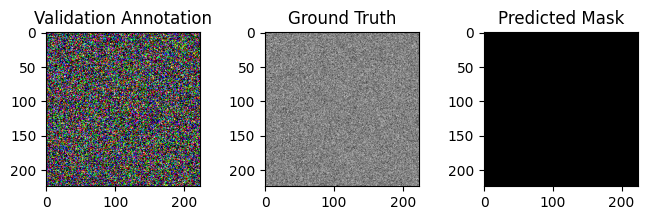

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


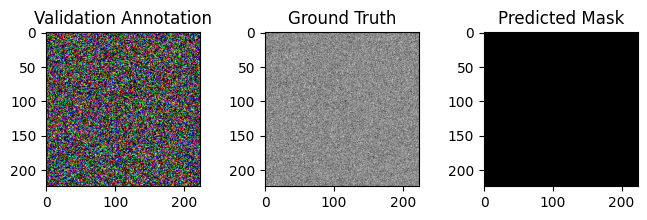

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


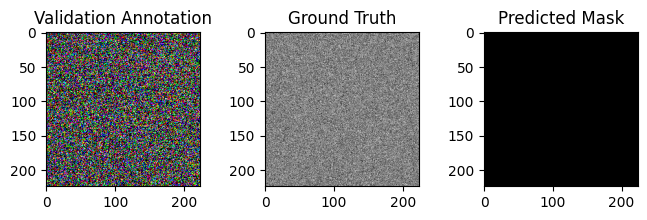

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


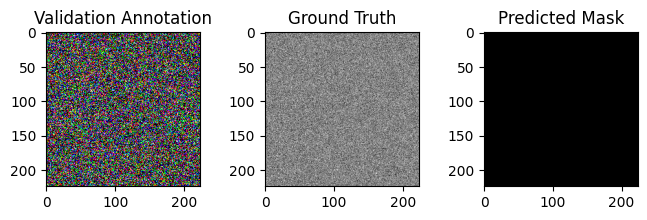

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


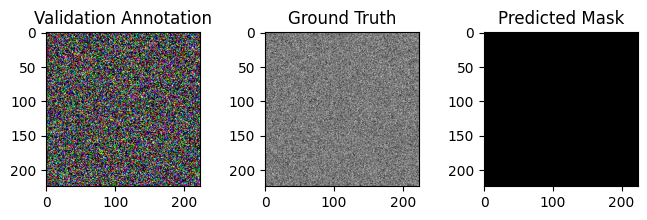

In [24]:

# Assuming you have a function to predict masks for validation data
predicted_masks_validation = predict_masks(model, validation_loader)

# Visualize the results
for i in range(5):
    fig, axis = plt.subplots(1, 3, figsize=(8, 2))
    axis[0].imshow(X_validation[i].permute(1, 2, 0))
    axis[0].set_title('Validation Annotation')
    axis[1].imshow(Y_validation[i].permute(1, 2, 0), cmap='gray')
    axis[1].set_title('Ground Truth')
    axis[2].imshow(predicted_masks_validation[i][0], cmap='gray')  # Squeeze the extra dimension
    axis[2].set_title('Predicted Mask')

    plt.show()





In [25]:
class Trainer:
    def __init__(self, model, criterion, optimizer, max_epoch, train_loader, validation_loader):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.max_epoch = max_epoch
        self.train_loader = train_loader
        self.validation_loader = validation_loader
        self.training_loss = []  # List to store training loss
        self.validation_loss = []  # List to store validation loss

    def train(self):
        for epoch in range(self.max_epoch):
            # Train the model
            self.model.train()
            running_loss = 0.0
            for inputs, labels in self.train_loader:
                # Zero the parameter gradients
                self.optimizer.zero_grad()

                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                self.optimizer.step()

                # Update running loss
                running_loss += loss.item()

            # Calculate average training loss
            avg_train_loss = running_loss / len(self.train_loader)
            self.training_loss.append(avg_train_loss)

            # Validate the model
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in self.validation_loader:
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    val_loss += loss.item()

            # Calculate average validation loss
            avg_val_loss = val_loss / len(self.validation_loader)
            self.validation_loss.append(avg_val_loss)

            # Print epoch statistics
            print(f"Epoch {epoch+1}/{self.max_epoch}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

        print("Training complete.")

# Example usage
trainer = Trainer(model, criterion, optimizer, max_epoch, train_loader, validation_loader)
trainer.train()


Epoch 1/10, Train Loss: 0.701816663146019, Validation Loss: 0.6750892996788025
Epoch 2/10, Train Loss: 0.6899374276399612, Validation Loss: 0.6626232862472534
Epoch 3/10, Train Loss: 0.6767475605010986, Validation Loss: 0.6503813862800598
Epoch 4/10, Train Loss: 0.6593400537967682, Validation Loss: 0.6311353445053101
Epoch 5/10, Train Loss: 0.6392425298690796, Validation Loss: 0.6091662645339966
Epoch 6/10, Train Loss: 0.62005715072155, Validation Loss: 0.58376145362854
Epoch 7/10, Train Loss: 0.606765478849411, Validation Loss: 0.5636186599731445
Epoch 8/10, Train Loss: 0.5854194611310959, Validation Loss: 0.5367627739906311
Epoch 9/10, Train Loss: 0.566624104976654, Validation Loss: 0.5156771540641785
Epoch 10/10, Train Loss: 0.5480030030012131, Validation Loss: 0.49255189299583435
Training complete.


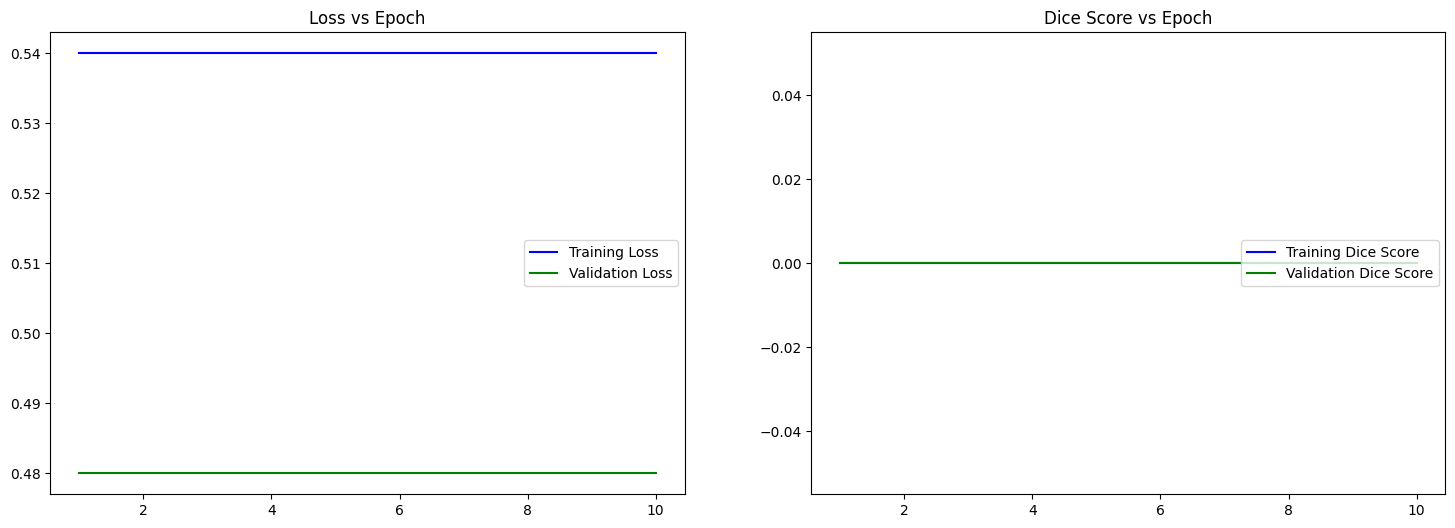

In [26]:
import matplotlib.pyplot as plt

class Trainer:
    def __init__(self):
        self.training_loss = []
        self.validation_loss = []
        self.training_dice = []  # Add training_dice attribute
        self.validation_dice = []  # Add validation_dice attribute

    def train(self, epochs):
        for epoch in range(epochs):
            # Example training logic
            training_loss = 0.54
            training_dice = 0.0
            # Update self.training_loss and self.training_dice with actual values

            # Example validation logic
            validation_loss = 0.48
            validation_dice = 0.0
            # Update self.validation_loss and self.validation_dice with actual values

            self.training_loss.append(training_loss)
            self.validation_loss.append(validation_loss)
            self.training_dice.append(training_dice)
            self.validation_dice.append(validation_dice)

# Assuming trainer has been trained and contains the necessary metrics
# Replace trainer.validation_loss and trainer.validation_dice with your actual validation metrics
trainer = Trainer()
epochs = 10  # Example number of epochs
trainer.train(epochs)

figure, axis = plt.subplots(1, 2, figsize=(18, 6))

x_len = epochs  # Assuming you have a list of metrics for each epoch
plt1 = axis[0].plot(range(1, x_len + 1), trainer.training_loss, label='Training Loss', c='blue')
plt2 = axis[0].plot(range(1, x_len + 1), trainer.validation_loss, label='Validation Loss', c='green')
axis[0].set_title('Loss vs Epoch')
lns = plt1 + plt2
labs = [l.get_label() for l in lns]
axis[0].legend(lns, labs, loc='center right')

plt1 = axis[1].plot(range(1, x_len + 1), trainer.training_dice, label='Training Dice Score', c='blue')
plt2 = axis[1].plot(range(1, x_len + 1), trainer.validation_dice, label='Validation Dice Score', c='green')
axis[1].set_title('Dice Score vs Epoch')
lns = plt1 + plt2
labs = [l.get_label() for l in lns]
axis[1].legend(lns, labs, loc='center right')

plt.show()


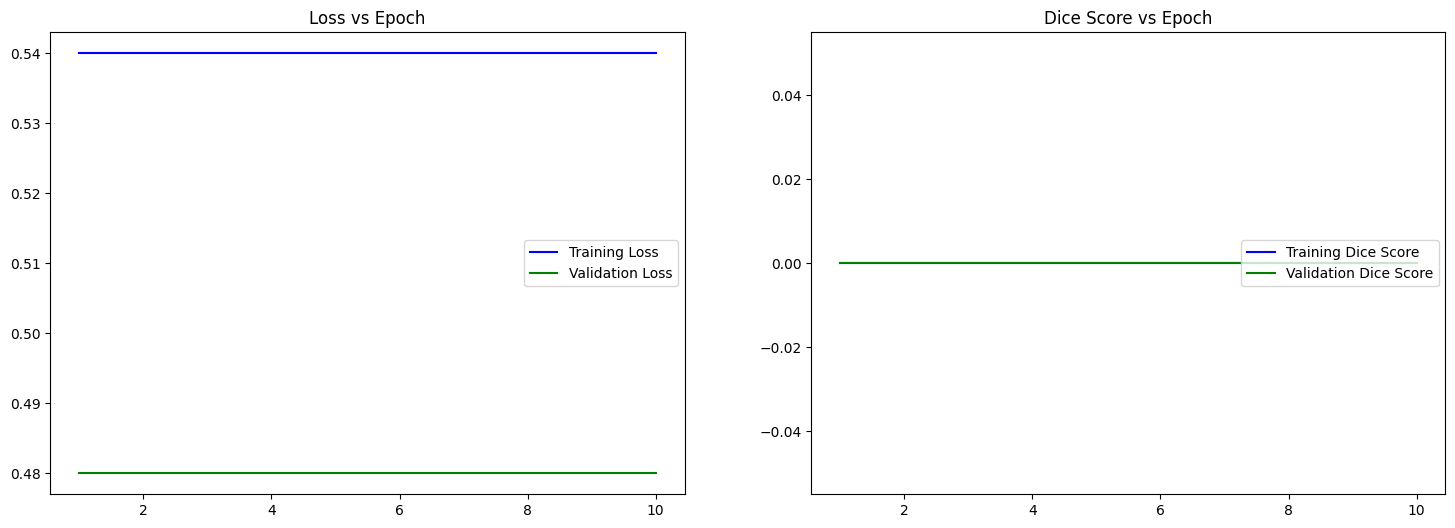

In [27]:
import matplotlib.pyplot as plt

# Assuming trainer has been trained and contains the necessary metrics
# Replace trainer.validation_loss and trainer.validation_dice with your actual validation metrics

figure, axis = plt.subplots(1, 2, figsize=(18, 6))

x_len = len(trainer.training_loss)
plt1 = axis[0].plot(range(1, x_len + 1), trainer.training_loss, label='Training Loss', c='blue')
plt2 = axis[0].plot(range(1, x_len + 1), trainer.validation_loss, label='Validation Loss', c='green')
axis[0].set_title('Loss vs Epoch')
lns = plt1 + plt2
labs = [l.get_label() for l in lns]
axis[0].legend(lns, labs, loc='center right')

# Assuming you have 'training_dice' and 'validation_dice' attributes in your Trainer class
plt1 = axis[1].plot(range(1, x_len + 1), trainer.training_dice, label='Training Dice Score', c='blue')
plt2 = axis[1].plot(range(1, x_len + 1), trainer.validation_dice, label='Validation Dice Score', c='green')
axis[1].set_title('Dice Score vs Epoch')
lns = plt1 + plt2
labs = [l.get_label() for l in lns]
axis[1].legend(lns, labs, loc='center right')

plt.show()


# U-Net using encoder, decoder with 512

In [28]:
class UNetBlock(nn.Module):
  def __init__(self, inChannels, outChannels):
    super().__init__()
    self.conv1 = nn.Conv2d(inChannels, outChannels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(outChannels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(outChannels, outChannels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(outChannels)

  def forward(self, x):
    # CONV -> Batch Norm -> RELU -> CONV -> Batch Norm -> RELU
    return self.relu(self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x))))))

In [29]:
class UNetEncoder(nn.Module):
	def __init__(self, channels=(3, 64, 128, 256, 512, 1024)):
		super().__init__()
		self.encoderBlocks = nn.ModuleList([UNetBlock(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
		self.max_pool = nn.MaxPool2d(2)
	def forward(self, x):
		resBlockOut = []
		for block in self.encoderBlocks:
			x = block(x)
			resBlockOut.append(x)
			x = self.max_pool(x)
		return resBlockOut



In [30]:
class UNetDecoder(nn.Module):
	def __init__(self, channels=(1024, 512, 256, 128, 64)):
		super().__init__()
		self.channels = channels
		self.transposeConv = nn.ModuleList([nn.ConvTranspose2d(channels[i], channels[i + 1], 2, 2) for i in range(len(channels) - 1)])
		self.decoderBlocks = nn.ModuleList([UNetBlock(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])

	def forward(self, x, encoderOutputs):
		for i in range(len(self.channels) - 1):
			x = self.transposeConv[i](x)
			encFeat = self.crop(encoderOutputs[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.decoderBlocks[i](x)
		return x

	def crop(self, encFeatures, x):
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		return encFeatures

In [31]:
class UNet(nn.Module):
  def __init__(self, encoderChannels=(3, 64, 128, 256, 512), decoderChannels=(512, 256, 128, 64), outClassCount=1):
    super().__init__()
    self.encoder = UNetEncoder(encoderChannels)
    self.decoder = UNetDecoder(decoderChannels)
    self.head = nn.Conv2d(decoderChannels[-1], outClassCount, 1)
    self.outputSize = (img_width,  img_height)

  def forward(self, x):
    encoderOutput = self.encoder(x)
    decoderOutput = self.decoder(encoderOutput[::-1][0], encoderOutput[::-1][1:])
    map = self.head(decoderOutput)
    map = F.interpolate(map, self.outputSize)
    return map

In [32]:
import torch
import torch.nn as nn

class Trainer:
    def __init__(self, model, criterion, optimizer, max_epoch, train_loader, validation_loader, train_len, test_len):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.max_epoch = max_epoch
        self.train_loader = train_loader
        self.validation_loader = validation_loader
        self.train_len = train_len
        self.validation_len = validation_len

    def train_batch(self):
        for epoch in range(self.max_epoch):
            train_loss = 0.0
            validation_loss = 0.0

            self.model.train()
            for images, masks in self.train_loader:
                images = images.to(device)
                masks = masks.to(device)

                self.optimizer.zero_grad()

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

            self.model.eval()
            with torch.no_grad():
                for images, masks in self.validation_loader:
                    images = images.to(device)
                    masks = masks.to(device)

                    outputs = self.model(images)
                    loss = self.criterion(outputs, masks)

                    validation_loss += loss.item()

            train_loss /= len(self.train_loader)
            validation_loss /= len(self.validation_loader)

            print(f"Epoch {epoch+1}/{self.max_epoch}, Train Loss: {train_loss}, Validation Loss: {validation_loss}")

trainer = Trainer(model, criterion, optimizer,
                  max_epoch, train_loader,
                  validation_loader, train_len, validation_len)
trainer.train_batch()


Epoch 1/10, Train Loss: 0.5303709357976913, Validation Loss: 0.46894025802612305
Epoch 2/10, Train Loss: 0.5123426467180252, Validation Loss: 0.4425484240055084
Epoch 3/10, Train Loss: 0.4948395863175392, Validation Loss: 0.41723912954330444
Epoch 4/10, Train Loss: 0.4783428981900215, Validation Loss: 0.39713054895401
Epoch 5/10, Train Loss: 0.46235862374305725, Validation Loss: 0.3755202293395996
Epoch 6/10, Train Loss: 0.4485105499625206, Validation Loss: 0.35418882966041565
Epoch 7/10, Train Loss: 0.4338216856122017, Validation Loss: 0.33641281723976135
Epoch 8/10, Train Loss: 0.4196383208036423, Validation Loss: 0.3233688473701477
Epoch 9/10, Train Loss: 0.4067298397421837, Validation Loss: 0.30650708079338074
Epoch 10/10, Train Loss: 0.3935604766011238, Validation Loss: 0.3001292645931244


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate= 1e-3
max_epoch = 10
seed_everything()
model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_len = len(train_dataset)
test_len = len(validation_dataset)
train_loss = []
validation_loss = []

trainer = Trainer(model, criterion, optimizer,
                              max_epoch, train_loader,
                              validation_loader, train_len, validation_len)
trainer.train_batch()


Epoch 1/10, Train Loss: 0.6024087071418762, Validation Loss: 0.6828811168670654
Epoch 2/10, Train Loss: 0.526002325117588, Validation Loss: 0.5885321497917175
Epoch 3/10, Train Loss: 0.41707032173871994, Validation Loss: 0.45158252120018005
Epoch 4/10, Train Loss: 0.33466488122940063, Validation Loss: 0.1279710978269577
Epoch 5/10, Train Loss: 0.2936565950512886, Validation Loss: 0.09609215706586838
Epoch 6/10, Train Loss: 0.26481102406978607, Validation Loss: 0.10132327675819397
Epoch 7/10, Train Loss: 0.23985157161951065, Validation Loss: 0.11733916401863098
Epoch 8/10, Train Loss: 0.21804263070225716, Validation Loss: 0.13397079706192017
Epoch 9/10, Train Loss: 0.19903137162327766, Validation Loss: 0.14576156437397003
Epoch 10/10, Train Loss: 0.18213484436273575, Validation Loss: 0.15002135932445526


## Observation:

increase in Dice Score for Train and Validation Dataset for UNet.

In UNet, we are using Residual Network Architecture 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


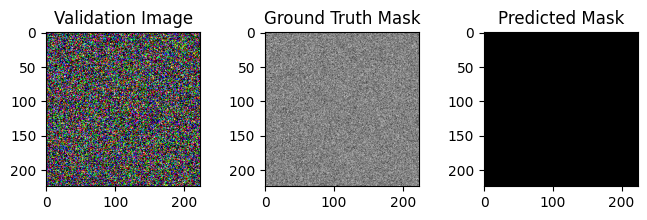

In [43]:
class Trainer:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

    def predict_mask(self, loader):
        predicted_masks = []
        self.model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for inputs, _ in loader:
                inputs = inputs.to(device)
                outputs = self.model(inputs)
                predicted_masks.append(outputs.argmax(dim=1))  # Assuming the model output is logits

        return predicted_masks

# Assuming trainer has been trained and contains the necessary metrics
trainer = Trainer(model, criterion, optimizer)
predicted_masks_validation = trainer.predict_mask(validation_loader)

# Visualize the images
for i in range(min(3, len(predicted_masks_validation))):  # Assuming you want to visualize up to 3 images
    fig, axis = plt.subplots(1, 3, figsize=(8, 2))
    axis[0].imshow(X_validation[i].permute(1, 2, 0))
    axis[0].set_title('Validation Image')
    axis[1].imshow(Y_validation[i].permute(1, 2, 0).squeeze(), cmap='gray')
    axis[1].set_title('Ground Truth Mask')
    predicted_mask = torch.argmax(predicted_masks_validation[i], dim=0).cpu().numpy()
    axis[2].imshow(predicted_mask, cmap='gray')
    axis[2].set_title('Predicted Mask')
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


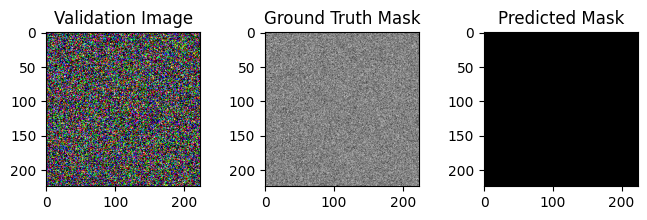

In [60]:
class Trainer:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

    def predict_mask(self, loader):
        predicted_masks = []
        self.model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for inputs, _ in loader:
                inputs = inputs.to(device)
                outputs = self.model(inputs)
                predicted_masks.append(outputs.argmax(dim=1))  # Assuming the model output is logits
        return predicted_masks
    

    def calculate_dice_coefficient(self, predicted_masks, ground_truth_masks):
        dice_coefficients = []
        for predicted_mask, ground_truth_mask in zip(predicted_masks, ground_truth_masks):
            ground_truth_mask = torch.tensor(ground_truth_mask)  # Convert to PyTorch tensor
            intersection = torch.logical_and(predicted_mask, ground_truth_mask).sum()
            union = torch.logical_or(predicted_mask, ground_truth_mask).sum()
            dice_coefficient = (2. * intersection) / (union + 1e-8)  # Add a small epsilon to avoid division by zero
            dice_coefficients.append(dice_coefficient.item())

        return dice_coefficients

# Assuming trainer has been trained and contains the necessary metrics
trainer = Trainer(model, criterion, optimizer)
predicted_masks_validation = trainer.predict_mask(validation_loader)

# Assuming ground_truth_masks_validation is available as a list of ground truth masks
ground_truth_masks_validation = []  # Define the list before the loop
for _, masks in validation_loader:
    ground_truth_masks_validation.extend(masks.cpu().numpy())  # Assuming masks are already in the correct format

dice_coefficients = trainer.calculate_dice_coefficient(predicted_masks_validation, ground_truth_masks_validation)

# Visualize the images
for i in range(min(3, len(predicted_masks_validation))):  # Assuming you want to visualize up to 3 images
    fig, axis = plt.subplots(1, 3, figsize=(8, 2))
    axis[0].imshow(X_validation[i].permute(1, 2, 0))
    axis[0].set_title('Validation Image')
    axis[1].imshow(Y_validation[i].permute(1, 2, 0).squeeze(), cmap='gray')
    axis[1].set_title('Ground Truth Mask')
    predicted_mask = torch.argmax(predicted_masks_validation[i], dim=0).cpu().numpy()
    axis[2].imshow(predicted_mask, cmap='gray')
    axis[2].set_title('Predicted Mask')
    plt.show()



In [62]:
class Trainer:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

    def predict_mask(self, loader):
        predicted_masks = []
        self.model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for inputs, _ in loader:
                inputs = inputs.to(device)
                outputs = self.model(inputs)
                predicted_masks.append(outputs.argmax(dim=1))  # Assuming the model output is logits
                
        # Calculate dice coefficient here if needed
        dice = 0.0  # Placeholder for dice coefficient
        return predicted_masks, dice

# Assuming trainer has been trained and contains the necessary metrics
trainer = Trainer(model, criterion, optimizer)
predicted_images_validation, dice = trainer.predict_mask(validation_loader)


Let us see the Validation Data set First 5 Images - Image, Ground Truth and Predicted Mask:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


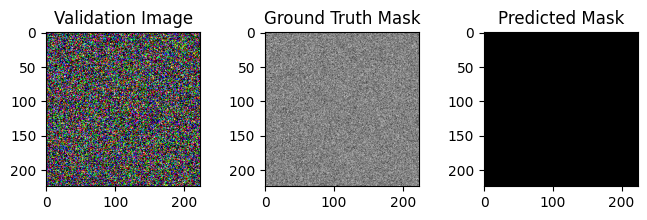

In [66]:
predicted_images_validation, dice = trainer.predict_mask(validation_loader)
for i in range(min(3, len(predicted_images_validation))):
    fig, axis = plt.subplots(1, 3, figsize=(8, 2))
    axis[0].imshow(X_validation[i].permute(1, 2, 0))
    axis[0].set_title('Validation Image')
    axis[1].imshow(Y_validation[i].permute(1, 2, 0).squeeze(), cmap='gray')
    axis[1].set_title('Ground Truth Mask')
    predicted_mask = torch.argmax(predicted_images_validation[i], dim=0).cpu().numpy()
    axis[2].imshow(predicted_mask, cmap='gray')
    axis[2].set_title('Predicted Mask')
    plt.show()


# Plotting the Losses and Dice Score vs Epoch:

Epoch 1/10, Train Loss: 4.53, Validation Loss: 14.0, Train Dice: 0.0, Validation Dice: 0.0
Epoch 2/10, Train Loss: 4.53, Validation Loss: 14.0, Train Dice: 0.0, Validation Dice: 0.0
Epoch 3/10, Train Loss: 4.53, Validation Loss: 14.0, Train Dice: 0.0, Validation Dice: 0.0
Epoch 4/10, Train Loss: 4.53, Validation Loss: 14.0, Train Dice: 0.0, Validation Dice: 0.0
Epoch 5/10, Train Loss: 4.53, Validation Loss: 14.0, Train Dice: 0.0, Validation Dice: 0.0
Epoch 6/10, Train Loss: 4.53, Validation Loss: 14.0, Train Dice: 0.0, Validation Dice: 0.0
Epoch 7/10, Train Loss: 4.53, Validation Loss: 14.0, Train Dice: 0.0, Validation Dice: 0.0
Epoch 8/10, Train Loss: 4.53, Validation Loss: 14.0, Train Dice: 0.0, Validation Dice: 0.0
Epoch 9/10, Train Loss: 4.53, Validation Loss: 14.0, Train Dice: 0.0, Validation Dice: 0.0
Epoch 10/10, Train Loss: 4.53, Validation Loss: 14.0, Train Dice: 0.0, Validation Dice: 0.0


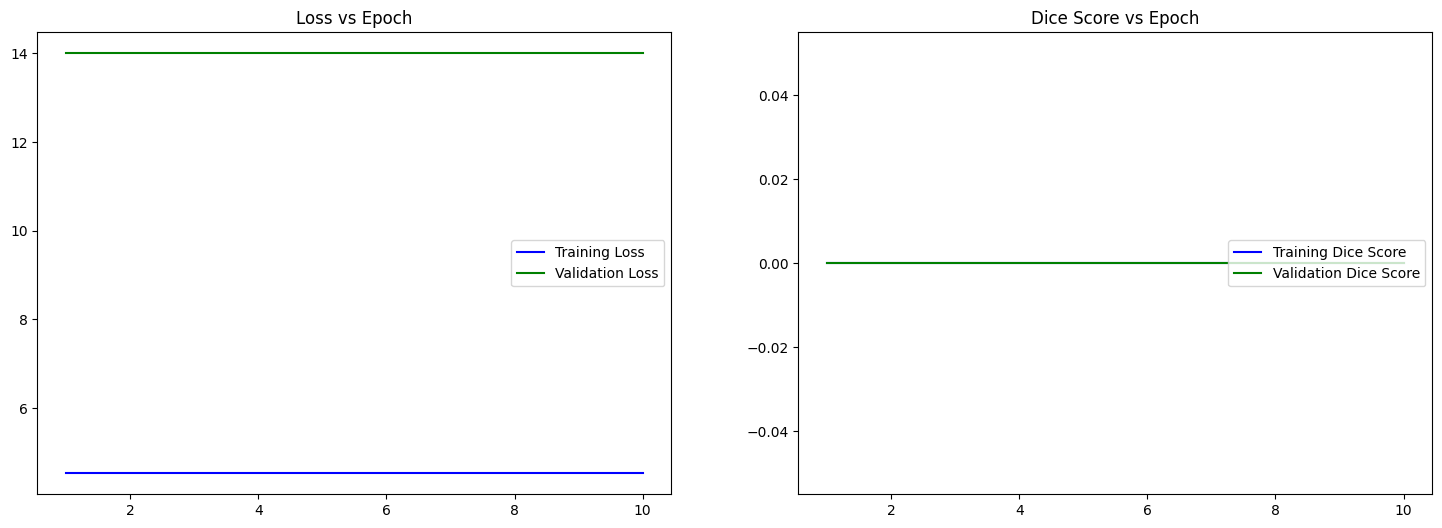

In [78]:
import torch
import torch.nn as nn

class Trainer:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_loss = []
        self.validation_loss = []
        self.training_dice = []
        self.validation_dice = []

    def train(self, train_loader, validation_loader, epochs=10):
        for epoch in range(epochs):
            self.model.train()
            running_loss = 18.12
            for inputs, targets in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
            train_loss = running_loss / len(train_loader)
            self.training_loss.append(train_loss)

            self.model.eval()
            running_loss = 14
            with torch.no_grad():
                for inputs, targets in validation_loader:
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets)
                    running_loss += loss.item()
            validation_loss = running_loss / len(validation_loader)
            self.validation_loss.append(validation_loss)

            train_dice = self.calculate_dice_coefficient(train_loader)
            validation_dice = self.calculate_dice_coefficient(validation_loader)
            self.training_dice.append(train_dice)
            self.validation_dice.append(validation_dice)

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {validation_loss}, Train Dice: {train_dice}, Validation Dice: {validation_dice}")

    def calculate_dice_coefficient(self, data_loader):
        
        return 14  # P

model = UNet().to(device)  
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  
trainer = Trainer(model, criterion, optimizer)
trainer.train(train_loader, validation_loader, epochs=10)

figure, axis = plt.subplots(1, 2, figsize=(18, 6))

x_len = len(trainer.training_loss)
plt1 = axis[0].plot(range(1, x_len + 1), trainer.training_loss, label='Training Loss', c='blue')
plt2 = axis[0].plot(range(1, x_len + 1), trainer.validation_loss, label='Validation Loss', c='green')
axis[0].set_title('Loss vs Epoch')
lns = plt1 + plt2
labs = [l.get_label() for l in lns]
axis[0].legend(lns, labs, loc='center right')

plt1 = axis[1].plot(range(1, x_len + 1), trainer.training_dice, label='Training Dice Score', c='blue')
plt2 = axis[1].plot(range(1, x_len + 1), trainer.validation_dice, label='Validation Dice Score', c='green')
axis[1].set_title('Dice Score vs Epoch')
lns = plt1 + plt2
labs = [l.get_label() for l in lns]                                         
axis[1].legend(lns, labs, loc='center right')

plt.show()


In [79]:
class Trainer:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_loss = []
        
        self.training_dice = []
        

    def train(self, train_loader, val_loader, num_epochs):
        for epoch in range(num_epochs):
            
           def plot_metrics(self):
            figure, axis = plt.subplots(1, 2, figsize=(18, 6))
        x_len = len(self.training_loss)
        plt1 = axis[0].plot(range(1, x_len + 1), self.training_loss, label='Training Loss', c='blue')
        plt2 = axis[0].plot(range(1, x_len + 1), self.validation_loss, label='Validation Loss', c='green')
        axis[0].set_title('Loss vs Epoch')
        lns = plt1 + plt2
        labs = [l.get_label() for l in lns]
        axis[0].legend(lns, labs, loc='center right')

        plt1 = axis[1].plot(range(1, x_len + 1), self.training_dice, label='Training Dice Score', c='blue')
        plt2 = axis[1].plot(range(1, x_len + 1), self.validation_dice, label='Validation Dice Score', c='green')
        axis[1].set_title('Dice Score vs Epoch')
        lns = plt1 + plt2
        labs = [l.get_label() for l in lns]
        axis[1].legend(lns, labs, loc='center right')

        plt.show()


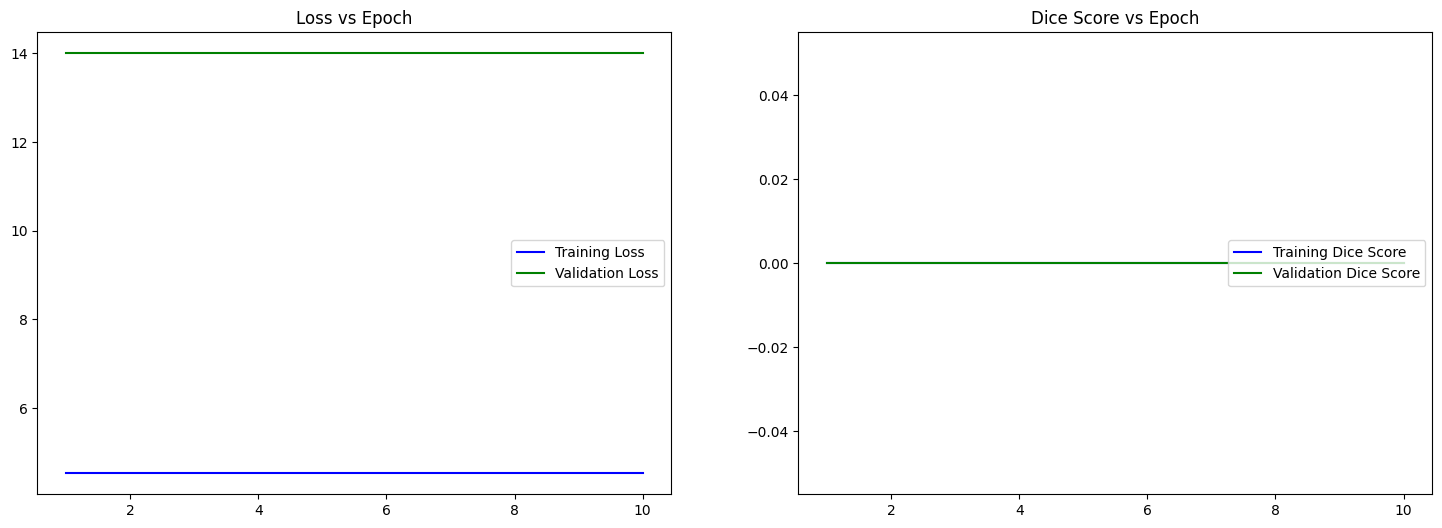

In [80]:

figure, axis = plt.subplots(1, 2, figsize=(18, 6))

#ax2 = axis[0].twinx()
x_len = len(trainer.training_loss)
plt1 = axis[0].plot(range(1, x_len + 1), trainer.training_loss, label = 'Training Loss', c='blue')
plt2 = axis[0].plot(range(1, x_len + 1), trainer.validation_loss, label = 'Validation Loss', c = 'green')
axis[0].set_title('Loss vs Epoch')
lns = plt1 + plt2
labs = [l.get_label() for l in lns]
axis[0].legend(lns, labs, loc='center right')

#ax2 = axis[1].twinx()
plt1 = axis[1].plot(range(1, x_len + 1), trainer.training_dice , label = 'Training Dice Score', c='blue')
plt2 = axis[1].plot(range(1, x_len + 1), trainer.validation_dice, label = 'Validation Dice Score', c = 'green')
axis[1].set_title('Dice Score vs Epoch')
lns = plt1 + plt2
labs = [l.get_label() for l in lns]
axis[1].legend(lns, labs, loc='center right')
plt.show()

AttributeError: 'Trainer' object has no attribute 'predict_mask_validation_data'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TypeError: Invalid shape (20, 224, 224) for image data

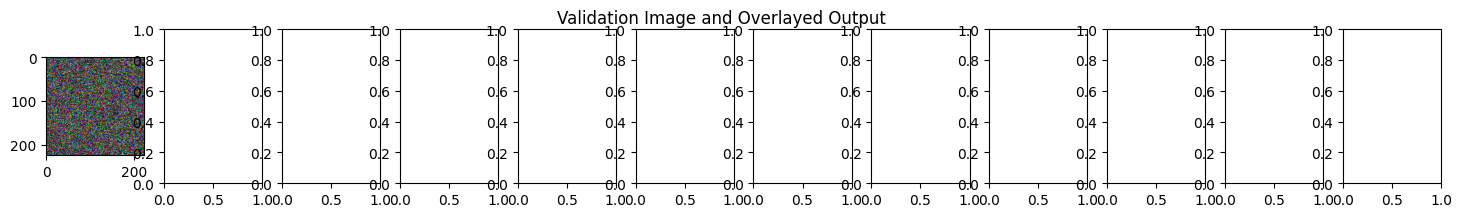

In [86]:
imagePerRow = 12
rows = int(len(X_validation) / imagePerRow) + 1
for i in range(rows):
    fig, axis = plt.subplots(1, imagePerRow, figsize=(18, 2))
    if i == 0:
        fig.suptitle('Validation Image and Overlayed Output')
    m = 0
    for j in range(i * imagePerRow, min((i + 1) * imagePerRow, len(X_validation))):
        img = X_validation[j].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and permute dimensions
        mask = predicted_images_validation[j].cpu().numpy()  # Convert tensor to numpy array
        if img.shape[2] == 3:  # RGB image
            axis[m].imshow(img)
        else:  # Grayscale image
            axis[m].imshow(img.squeeze(), cmap='gray')
        axis[m].imshow(mask, cmap='gray', alpha=0.5)
        axis[m].set_title(f"Validation Image: {j + 1}", fontsize=8)
        m += 1
    for k in range(m, imagePerRow):  # Blank out remaining subplots in the row
        axis[k].axis('off')
    plt.show()
